# Deblurring Dataset

## Prerequisite
We need to blur image first

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import os
import random
from tqdm import tqdm
import tensorflow as tf

Read image

In [23]:
origin_paths = []

for file in tqdm(os.listdir('Immunofluorescence images')):
    origin_paths.append('Immunofluorescence images/' + file)

print(origin_paths[0:5])

100%|██████████| 592/592 [00:00<00:00, 3233109.33it/s]

['Immunofluorescence images/1H_Nrf2_No_AP39_9_DAPI.tif', 'Immunofluorescence images/1H_Nrf2_No_AP39_8_DAPI.tif', 'Immunofluorescence images/1H_Nrf2_UV_HTB_4_FITC.tif', 'Immunofluorescence images/1H_Nrf2_No_AP39_1_merged.tif', 'Immunofluorescence images/1H_Nrf2_UV_HTB_5_FITC.tif']


In [30]:
origin_paths[0][26:-4]

'1H_Nrf2_No_AP39_9_DAPI'

Average Blur & Gaussian Blur preview

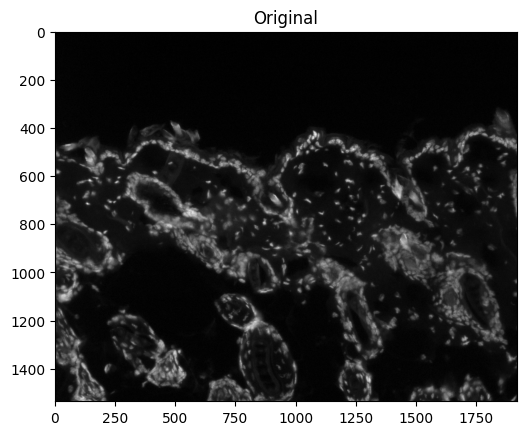

In [20]:
img = cv2.imread(origin_paths[0], 0)
plot = plt.imshow(img, cmap='gray')
plt.title('Original')
plt.show()

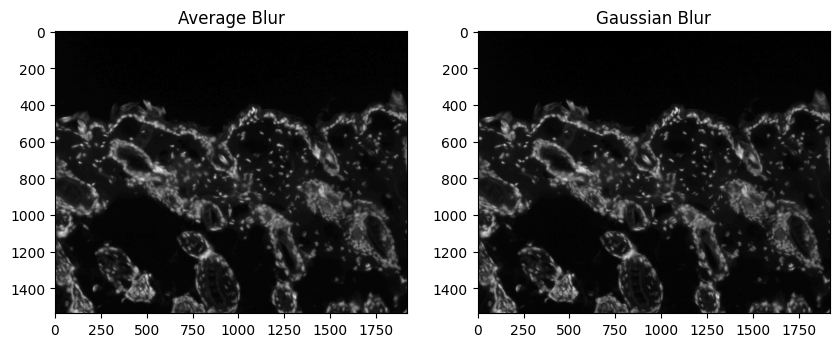

In [22]:
# Average blur
avg_blur = cv2.blur(img, (5,5))
gss_blur = cv2.GaussianBlur(img, (5,5), 0)

fig = plt.figure(10, (10,10))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(avg_blur, cmap='gray')
ax.set_title('Average Blur')
ax = fig.add_subplot(1, 2, 2)
ax.imshow(gss_blur, cmap='gray')
ax.set_title('Gaussian Blur')
plt.show()

Create blur dataset

Immunofluorescence images/1H_Nrf2_UV_HSP_200_8_merged.tif


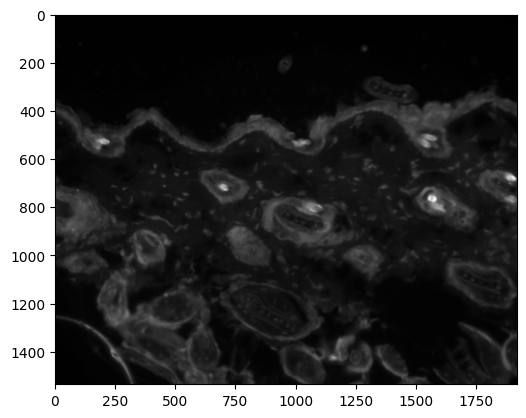

In [38]:
print(origin_paths[96])
img = cv2.imread(origin_paths[96], 0)
g = cv2.blur(img, (5,5), 0)
plot = plt.imshow(g, cmap='gray')

In [33]:
for path in tqdm(origin_paths):
    img = cv2.imread(path, 0)
    avg_blur = cv2.blur(img, (5,5))
    gss_blur = cv2.GaussianBlur(img, (5,5), 0)

    img_name = path[26:-4]
    avg_path = 'Blur images/Average Blur/' + img_name + '.png'
    gss_path = 'Blur images/Gaussian Blur/' + img_name + '.png'
    
    cv2.imwrite(avg_path, avg_blur)
    cv2.imwrite(gss_path, gss_blur)

 16%|█▋        | 97/592 [00:01<00:09, 50.94it/s]


error: OpenCV(4.6.0) /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_562_cazh1h/croots/recipe/opencv-suite_1664548333142/work/modules/imgproc/src/box_filter.dispatch.cpp:446: error: (-215:Assertion failed) !_src.empty() in function 'boxFilter'


## 1. CNN

In [ ]:
origin_images = 'Immunofluorescence images'
blur_images = 